In [8]:
import os
import json

from functools import partial

from pathlib import Path
import pandas as pd
import numpy as np
import polars as pl
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from astropy.stats import sigma_clip

from scipy.signal import savgol_filter
from scipy.optimize import minimize

from tqdm.auto import tqdm

import scipy

from sklearn.linear_model import Ridge, LinearRegression

from sklearn.model_selection import cross_val_predict
from sklearn.metrics import mean_squared_error, r2_score

from xgboost import XGBRegressor

from concurrent.futures import ProcessPoolExecutor

## Load Data

In [2]:
nums_parallel = 48
DATA_ROOT = '../input/'
cut_inf, cut_sup = 39, 321

In [4]:
train_processed = np.load('trim_train_processed.npz')
trim_f_raw_train, trim_a_raw_train = train_processed['f_raw_train'], train_processed['a_raw_train']

trim_a_raw_train = trim_a_raw_train[:, :, cut_inf:cut_sup]
trim_a_raw_train_mean = trim_a_raw_train.mean(axis=-1)

trim_f_raw_train.shape, trim_a_raw_train.shape, trim_a_raw_train_mean.shape

((673, 67500), (673, 5625, 282), (673, 5625))

In [6]:
train_label_df = pd.read_csv(f'{DATA_ROOT}/train_labels.csv', index_col='planet_id')
wavelengths = pd.read_csv(f'{DATA_ROOT}/wavelengths.csv')
axis_info = pd.read_parquet(f'{DATA_ROOT}/axis_info.parquet')

In [5]:
train_adc_df = pd.read_pickle('train_adc_info_with_transit_zone2.pkl')

In [7]:
train_adc_df.head()

,FGS1_adc_offset,FGS1_adc_gain,AIRS-CH0_adc_offset,AIRS-CH0_adc_gain,star,breakpoints,r0,r1,f_depth,a_depth,all_depth,f_depth2,a_wv_depth,trim_f_depth,trim_a_depth,trim_a_wv_depth,a_label_mean,ariel_only_a_depth,ariel_only_update_a_depth,ariel_only_update_a_depth2
planet_id,,,,,,,,,,,,,,,,,,,,
785834,-343.335938,0.837244,-778.916533,0.924746,1,"{'AIRS-CH0': [1779, 3845], 'FGS1': [21374, 461...",12.014615,11.996359,0.00105,0.001300,"(0.001400000000000001, 0.0012625000000000006)",0.00105,"[0.001, 0.001, 0.00015, 0.00105, 0.0002, 0.001...",0.00140,0.001263,"[0.001, 0.00105, 0.0002, 0.0002, 0.000125, 0.0...",0.001130,0.000975,0.001335,0.001335
14485303,-366.381992,0.842983,-740.323212,0.931727,1,"{'AIRS-CH0': [1786, 3838], 'FGS1': [22167, 453...",12.411534,11.811621,0.00205,0.001900,"(0.0019500000000000032, 0.0018875000000000029)",0.00205,"[0.001, 0.001, 0.00105, 0.001, 0.001, 0.001, 0...",0.00195,0.001888,"[0.001, 0.001, 0.0002, 0.00105, 0.001, 0.001, ...",0.001902,0.002050,0.001875,0.001875
17002355,-386.107037,1.041701,-808.690659,1.513541,0,"{'AIRS-CH0': [1807, 3817], 'FGS1': [21432, 460...",11.860542,12.069164,0.00285,0.002725,"(0.0031000000000000077, 0.002750000000000006)",0.00285,"[0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.0...",0.00310,0.002750,"[0.0002, 0.001, 0.00105, 0.001, 0.00205, 0.002...",0.002801,0.002600,0.002755,0.002755
24135240,-339.737490,0.840239,-776.124167,0.931277,1,"{'AIRS-CH0': [1810, 3814], 'FGS1': [22486, 450...",12.423204,11.802307,0.00105,0.001450,"(0.0011500000000000004, 0.0014500000000000014)",0.00105,"[0.001, 0.00105, 0.00105, 0.001, 0.001, 0.0002...",0.00115,0.001450,"[0.001, 0.001, 0.00105, 0.0002, 0.0002, 0.0010...",0.001445,0.001425,0.001435,0.001435
25070640,-355.660433,1.041280,-848.371494,1.503923,0,"{'AIRS-CH0': [1964, 3660], 'FGS1': [23835, 436...",12.135947,11.930328,0.00180,0.001950,"(0.0017500000000000024, 0.0020250000000000034)",0.00180,"[0.00105, 0.001, 0.001, 0.001, 0.001, 0.001, 0...",0.00175,0.002025,"[0.001, 0.001, 0.001, 0.001, 0.0002, 0.00105, ...",0.001998,0.001750,0.002005,0.002005


## Metric

In [9]:
def get_cv_score(pred_array, sigma_pred):
    sub_df = create_submission(pred_array, train_label_df.index, sigma_pred)
    score = competition_score(
        solution=train_label_df,
        submission=sub_df,
        naive_mean=train_label_df.values.mean(),
        naive_sigma=train_label_df.values.std(),
        sigma_true=10e-6,  # 10ppm
    )
    return score

def create_submission(pred_array, index, sigma_pred):
    """Create a submission dataframe from its components
    
    Parameters:
    pred_array: ndarray of shape (n_samples, 283)
    index: pandas.Index of length n_samples with name 'planet_id'
    sigma_pred: float
    
    Return value:
    df: DataFrame of shape (n_samples, 566) with planet_id as index
    """
    return pd.concat([pd.DataFrame(pred_array.clip(0, None), index=index, columns=wavelengths.columns),
                      pd.DataFrame(sigma_pred, index=index, columns=[f"sigma_{i}" for i in range(1, 284)])],
                     axis=1)

# Adapted from https://www.kaggle.com/code/metric/ariel-gaussian-log-likelihood
class ParticipantVisibleError(Exception):
    pass

def competition_score(
        solution: pd.DataFrame,
        submission: pd.DataFrame,
        naive_mean: float,
        naive_sigma: float,
        sigma_true: float,
    ) -> float:
    '''
    This is a Gaussian Log Likelihood based metric. For a submission, which contains the predicted mean (x_hat) and variance (x_hat_std),
    we calculate the Gaussian Log-likelihood (GLL) value to the provided ground truth (x). We treat each pair of x_hat,
    x_hat_std as a 1D gaussian, meaning there will be 283 1D gaussian distributions, hence 283 values for each test spectrum,
    the GLL value for one spectrum is the sum of all of them.

    Inputs:
        - solution: Ground Truth spectra (from test set)
            - shape: (nsamples, n_wavelengths)
        - submission: Predicted spectra and errors (from participants)
            - shape: (nsamples, n_wavelengths*2)
        naive_mean: (float) mean from the train set.
        naive_sigma: (float) standard deviation from the train set.
        sigma_true: (float) essentially sets the scale of the outputs.
    '''

    if submission.min().min() < 0:
        raise ParticipantVisibleError('Negative values in the submission')
    for col in submission.columns:
        if not pd.api.types.is_numeric_dtype(submission[col]):
            raise ParticipantVisibleError(f'Submission column {col} must be a number')

    n_wavelengths = len(solution.columns)
    if len(submission.columns) != n_wavelengths*2:
        raise ParticipantVisibleError('Wrong number of columns in the submission')

    y_pred = submission.iloc[:, :n_wavelengths].values
    # Set a non-zero minimum sigma pred to prevent division by zero errors.
    sigma_pred = np.clip(submission.iloc[:, n_wavelengths:].values, a_min=10**-15, a_max=None)
    y_true = solution.values

    GLL_pred = np.sum(scipy.stats.norm.logpdf(y_true, loc=y_pred, scale=sigma_pred))
    GLL_true = np.sum(scipy.stats.norm.logpdf(y_true, loc=y_true, scale=sigma_true * np.ones_like(y_true)))
    GLL_mean = np.sum(scipy.stats.norm.logpdf(y_true, loc=naive_mean * np.ones_like(y_true), scale=naive_sigma * np.ones_like(y_true)))

    submit_score = (GLL_pred - GLL_mean)/(GLL_true - GLL_mean)
    return float(np.clip(submit_score, 0.0, 1.0))

## FE

In [11]:
FGS1_BUFFER_SIZE = 1500
AIRS_BUFFER_SIZE = 120

In [12]:
airs_global_breakpoints = [1708, 1958, 3666, 3916]
fgs1_global_breakpoints = [20500, 23500, 44000, 47000]

In [13]:
def get_transit_depth(signal, breakpoints, half=False, devide_in_transit=False, single_example=False):
    '''  ----p1-p2--p3-p4----
    signal: N x T
    breakpoints: [p1, p2, p3, p4]
    half: 半凌日
    '''
    if single_example:
        signal = signal.reshape(1, -1)  # 1 x T
    
    p1, p2, p3, p4 = breakpoints
    out_transit = np.column_stack([signal[:, :p1], signal[:, p4:]])

    if half:
        in_transit = np.column_stack([signal[:, p1:p2], signal[:, p3:p4]])
    else:
        in_transit = signal[:, p2:p3]

    out_transit = out_transit.mean(axis=-1)
    in_transit = in_transit.mean(axis=-1)

    if devide_in_transit:
        depth = (out_transit - in_transit) / in_transit
    else:
        depth = (out_transit - in_transit) / out_transit
        
    depth = depth.clip(0)  # (N,)

    if single_example:
        depth = depth.item()
    
    return depth

In [14]:
def get_transit_depth_multi_wv(signal, breakpoints, half=False, devide_in_transit=False, single_example=False):
    '''  ----p1-p2--p3-p4----
    signal: N x T x 282
    breakpoints: [p1, p2, p3, p4]
    half: 半凌日
    '''
    if single_example:
        signal = signal[np.newaxis]  # 1 x T x 282
    
    p1, p2, p3, p4 = breakpoints
    out_transit = np.column_stack([signal[:, :p1], signal[:, p4:]])

    if half:
        in_transit = np.column_stack([signal[:, p1:p2], signal[:, p3:p4]])
    else:
        in_transit = signal[:, p2:p3]

    out_transit = out_transit.mean(axis=1)  # over T axis -> N x 282
    in_transit = in_transit.mean(axis=1)  # over T axis  -> N x 282

    if devide_in_transit:
        depth = (out_transit - in_transit) / in_transit
    else:
        depth = (out_transit - in_transit) / out_transit
        
    depth = depth.clip(0)  # (N, 282)

    if single_example:
        depth = depth.flatten()
    
    return depth

In [18]:
def fe_transit_depth_mean_wv(f_raw, a_raw, devide_in_transit=False, polyfit=False):
    '''
    desc:
        1.凌日起止点用整个训练集公共的
        2.airs 282个波段取平均
    input:
        f_raw: (N, 67500)
        a_raw: (N, 5625)

    return:
        ndarray of shape (N, 2)
    '''
    if polyfit:  # 多项式拟合得到的凌日深度
        return train_adc_df[['trim_f_depth', 'trim_a_depth']].values
    
    f_depth = get_transit_depth(f_raw, fgs1_global_breakpoints, devide_in_transit=devide_in_transit) # (N,)
    a_depth = get_transit_depth(a_raw, airs_global_breakpoints, devide_in_transit=devide_in_transit) # (N,)

    res = np.row_stack([f_depth, a_depth]).transpose()  # (N,2)
    return res

In [16]:
def fe_independent_transit_depth_mean_wv(f_raw, a_raw, airs_only=False, add_half=False):
    '''
    desc:
        1.使用find_transit_zone算法精确定位的凌日起止点
        2.airs 282个波段取平均
    input:
        airs_only: 由于airs信号更精准，可以考虑只使用airs探测到的凌日起止点，fgs1起止点可通过✖️12转换得到
    return:
        ndarray of shape (N, 2)
    '''
    res = []
    
    for f_signal, a_signal, breakpoints in tqdm(zip(f_raw, a_raw, train_adc_df.breakpoints)):
        # AIRS
        bp1, bp2 = breakpoints['AIRS-CH0']
        bps = [bp1 - AIRS_BUFFER_SIZE, bp1 + AIRS_BUFFER_SIZE, bp2 - AIRS_BUFFER_SIZE, bp2 + AIRS_BUFFER_SIZE]
        # print('AIRS:', bps)
        a_depth = get_transit_depth(a_signal, bps, devide_in_transit=True, single_example=True)
        a_half_depth = get_transit_depth(a_signal, bps, devide_in_transit=False, single_example=True, half=True)
        # print('a_depth', a_depth)

        # FGS1
        if airs_only:
            bps = [x * 12 for x in bps]
            # print('FGS1:', bps)
        else:
            bp1, bp2 = breakpoints['FGS1']
            bps = [bp1 - FGS1_BUFFER_SIZE, bp1 + FGS1_BUFFER_SIZE, bp2 - FGS1_BUFFER_SIZE, bp2 + FGS1_BUFFER_SIZE]
            # print('FGS1:', bps)

        f_depth = get_transit_depth(f_signal, bps, devide_in_transit=True, single_example=True)
        f_half_depth = get_transit_depth(f_signal, bps, devide_in_transit=False, single_example=True, half=True)
        # print('f_depth', f_depth)

        if add_half:
            res.append([f_depth, f_half_depth, a_depth, a_half_depth])
        else:
            res.append([f_depth, a_depth])

    return np.array(res, dtype=np.float32)

In [17]:
def fe_independent_transit_depth_multi_wv(f_raw, a_raw, airs_only=False, add_half=False):
    '''
    desc:
        1.使用find_transit_zone算法精确定位的凌日起止点
        2.airs 282个波段各自计算凌日深度
    input:
        f_raw: (N, T)
        a_raw: (N, T, 282)
        airs_only: 由于airs信号更精准，可以考虑只使用airs探测到的凌日起止点，fgs1起止点可通过✖️12转换得到
    return:
        ndarray of shape (N, 2)
    '''
    res = []
    
    for f_signal, a_signal, breakpoints in tqdm(zip(f_raw, a_raw, train_adc_df.breakpoints)):
        # AIRS
        bp1, bp2 = breakpoints['AIRS-CH0']
        bps = [bp1 - AIRS_BUFFER_SIZE, bp1 + AIRS_BUFFER_SIZE, bp2 - AIRS_BUFFER_SIZE, bp2 + AIRS_BUFFER_SIZE]
        # print('AIRS:', bps)
        a_depth = get_transit_depth_multi_wv(a_signal, bps, devide_in_transit=True, single_example=True)  # (282,)
        a_half_depth = get_transit_depth_multi_wv(a_signal, bps, devide_in_transit=True, single_example=True, half=True)  # (282,)
        # print('a_depth', a_depth)

        # FGS1
        if airs_only:
            bps = [x * 12 for x in bps]
            # print('FGS1:', bps)
        else:
            bp1, bp2 = breakpoints['FGS1']
            bps = [bp1 - FGS1_BUFFER_SIZE, bp1 + FGS1_BUFFER_SIZE, bp2 - FGS1_BUFFER_SIZE, bp2 + FGS1_BUFFER_SIZE]
            # print('FGS1:', bps)

        f_depth = get_transit_depth(f_signal, bps, devide_in_transit=True, single_example=True)  # (1,)
        f_half_depth = get_transit_depth(f_signal, bps, devide_in_transit=True, single_example=True, half=True)  # (1,)
        # print('f_depth', f_depth)

        res.append(
            np.concatenate([[f_depth], [f_half_depth], a_depth, a_half_depth])  # (566,)
        )

    return np.row_stack(res)  # N x 566

In [19]:
# 凌日起止点用整个训练集公共的，airs 282个波段取平均
feat1 = fe_transit_depth_mean_wv(trim_f_raw_train, trim_a_raw_train_mean)
feat1.shape

(673, 2)

In [20]:
# 凌日起止点用整个训练集公共的，airs 282个波段取平均；计算凌日深度时，分母用in_transit
feat2 = fe_transit_depth_mean_wv(trim_f_raw_train, trim_a_raw_train_mean, devide_in_transit=True)
feat2.shape

(673, 2)

In [23]:
# 凌日起止点用各行星的准确起止点; airs 282个波段取平均; 计算凌日深度时，分母用in_transit
feat3 = fe_independent_transit_depth_mean_wv(trim_f_raw_train, trim_a_raw_train_mean, airs_only=True, add_half=True)
feat3.shape

0it [00:00, ?it/s]

(673, 4)

In [26]:
# - FE:
#   - 凌日起止点用各行星的准确起止点(airs更准确，用airs探测起止点，折算成fgs1的起止点)
#   - airs 282个波段各自计算凌日深度
#   - 计算凌日深度时，分母用in_transit
#   - 增加半凌日
feat4 = fe_independent_transit_depth_multi_wv(trim_f_raw_train, trim_a_raw_train, airs_only=True, add_half=True)
feat4.shape

0it [00:00, ?it/s]

(673, 566)

In [27]:
# - FE:
#   - 凌日起止点用各行星的准确起止点(airs更准确，用airs探测起止点，折算成fgs1的起止点)
#   - 多项式拟合凌日深度
feat5 = fe_transit_depth_mean_wv(trim_f_raw_train, trim_a_raw_train, polyfit=True)
feat5.shape

(673, 2)

In [28]:
# - FE:
#   - 凌日起止点用各行星的准确起止点(airs更准确，用airs探测起止点，折算成fgs1的起止点)
#   - 多项式拟合凌日深度
#   - airs每个波段都独立计算凌日深度
feat6 = np.column_stack([
    train_adc_df[['trim_f_depth']].values,  # N x 1
    train_adc_df[['trim_a_depth']].values,  # N x 1
    np.row_stack(train_adc_df['trim_a_wv_depth'].tolist()),  # N x 282
])
feat6.shape

(673, 284)

In [36]:
X_train = np.column_stack([
    feat1,
    feat2,
    feat3,
    feat4,
    feat5,
    feat6,
])

Y_train = train_label_df.values

In [37]:
X_train.shape, Y_train.shape

((673, 860), (673, 283))

## Optuna调参

In [53]:
import optuna

### KNN

In [33]:
from sklearn.neighbors import KNeighborsRegressor

In [39]:
model = KNeighborsRegressor(n_neighbors=5)

In [45]:
oof_pred = cross_val_predict(model, X_train, Y_train, cv=3)

In [48]:
sigma_pred = mean_squared_error(Y_train, oof_pred, squared=False)
sigma_pred

0.000145160832740702

In [49]:
get_cv_score(oof_pred, sigma_pred)

0.4369851729834575

In [55]:
def objective(trial):
    # 定义搜索空间
    n_neighbors = trial.suggest_int('n_neighbors', 1, 50)
    weights = trial.suggest_categorical('weights', ['uniform', 'distance'])
    algorithm = trial.suggest_categorical('algorithm', ['auto', 'ball_tree', 'kd_tree', 'brute'])
    p = trial.suggest_int('p', 1, 2)
    
    # 创建KNN模型
    knn = KNeighborsRegressor(
        n_neighbors=n_neighbors,
        weights=weights,
        algorithm=algorithm,
        p=p
    )
    
    # 使用交叉验证进行评估
    oof_pred = cross_val_predict(knn, X_train, Y_train, cv=3)
    sigma_pred = mean_squared_error(Y_train, oof_pred, squared=False)
    score = get_cv_score(oof_pred, sigma_pred)

    return score  # 越大越好

In [58]:
study = optuna.create_study(
    storage="sqlite:///db.sqlite3",
    study_name="knn_hpo2",
    direction="maximize",
)
study.optimize(objective, n_trials=100)

[I 2024-10-07 17:43:29,399] A new study created in RDB with name: knn_hpo2
[I 2024-10-07 17:43:29,627] Trial 0 finished with value: 0.4097372926913031 and parameters: {'n_neighbors': 25, 'weights': 'distance', 'algorithm': 'auto', 'p': 2}. Best is trial 0 with value: 0.4097372926913031.
[I 2024-10-07 17:43:29,975] Trial 1 finished with value: 0.37154260594399535 and parameters: {'n_neighbors': 43, 'weights': 'uniform', 'algorithm': 'brute', 'p': 1}. Best is trial 0 with value: 0.4097372926913031.
[I 2024-10-07 17:43:30,170] Trial 2 finished with value: 0.4038044710916296 and parameters: {'n_neighbors': 29, 'weights': 'distance', 'algorithm': 'brute', 'p': 2}. Best is trial 0 with value: 0.4097372926913031.
[I 2024-10-07 17:43:30,317] Trial 3 finished with value: 0.4177396915035603 and parameters: {'n_neighbors': 18, 'weights': 'uniform', 'algorithm': 'auto', 'p': 2}. Best is trial 3 with value: 0.4177396915035603.
[I 2024-10-07 17:43:30,818] Trial 4 finished with value: 0.4414292935809

In [59]:
study.best_value

0.4418395891122093

In [60]:
study.best_params

{'n_neighbors': 3, 'weights': 'distance', 'algorithm': 'kd_tree', 'p': 2}

In [61]:
model = KNeighborsRegressor(**study.best_params)

In [62]:
oof_pred = cross_val_predict(model, X_train, Y_train, cv=3)

In [63]:
sigma_pred = mean_squared_error(Y_train, oof_pred, squared=False)
sigma_pred

0.00014127883261157837

In [64]:
get_cv_score(oof_pred, sigma_pred)

0.4418395891122093

### Ridge

In [66]:
def objective(trial):
    # 定义搜索空间
    alpha = trial.suggest_float('alpha', 1e-12, 1.0, log=True)
    
    # 创建模型
    model = Ridge(alpha=alpha)
    
    # 使用交叉验证进行评估
    oof_pred = cross_val_predict(model, X_train, Y_train, cv=3)
    sigma_pred = mean_squared_error(Y_train, oof_pred, squared=False)
    score = get_cv_score(oof_pred, sigma_pred)

    return score  # 越大越好

In [67]:
study = optuna.create_study(
    storage="sqlite:///db.sqlite3",
    study_name="ridge_hpo",
    direction="maximize",
)
study.optimize(objective, n_trials=100)

[I 2024-10-07 18:11:30,857] A new study created in RDB with name: ridge_hpo
[I 2024-10-07 18:11:31,173] Trial 0 finished with value: 0.5223595221846613 and parameters: {'alpha': 2.417832931906195e-10}. Best is trial 0 with value: 0.5223595221846613.
[I 2024-10-07 18:11:31,479] Trial 1 finished with value: 0.522356197551893 and parameters: {'alpha': 1.7930761208149865e-11}. Best is trial 0 with value: 0.5223595221846613.
[I 2024-10-07 18:11:31,770] Trial 2 finished with value: 0.5223564828978885 and parameters: {'alpha': 3.714250795606095e-11}. Best is trial 0 with value: 0.5223595221846613.
[I 2024-10-07 18:11:32,020] Trial 3 finished with value: 0.5891972248135122 and parameters: {'alpha': 0.00021582227565879495}. Best is trial 3 with value: 0.5891972248135122.
[I 2024-10-07 18:11:32,250] Trial 4 finished with value: 0.35257894521479355 and parameters: {'alpha': 0.08326671956323714}. Best is trial 3 with value: 0.5891972248135122.
[I 2024-10-07 18:11:32,489] Trial 5 finished with valu

### XGBoost

In [68]:
def objective(trial):
    learning_rate = trial.suggest_float('learning_rate', 1e-3, 1.0, log=True)
    max_depth = trial.suggest_int('max_depth', 1, 9)
    min_child_weight = trial.suggest_int('min_child_weight', 1, 100)
    subsample = trial.suggest_float('subsample', 0.1, 1.0)
    colsample_bytree = trial.suggest_float('colsample_bytree', 0.1, 1.0)
    reg_lambda = trial.suggest_float('reg_lambda', 1e-3, 1e3, log=True)

    model = XGBRegressor(
        n_estimators=100,
        learning_rate=learning_rate,
        max_depth=max_depth,
        min_child_weight=min_child_weight,
        subsample=subsample,
        colsample_bytree=colsample_bytree,
        reg_lambda=reg_lambda,
    )

    # 使用交叉验证进行评估
    oof_pred = cross_val_predict(model, X_train, Y_train, cv=3)
    sigma_pred = mean_squared_error(Y_train, oof_pred, squared=False)
    score = get_cv_score(oof_pred, sigma_pred)

    return score  # 越大越好

In [ ]:
study = optuna.create_study(
    storage="sqlite:///db.sqlite3",
    study_name="xgb_hpo",
    direction="maximize",
)
study.optimize(objective, n_trials=100)

[I 2024-10-07 18:22:20,779] A new study created in RDB with name: xgb_hpo
[I 2024-10-07 18:29:46,725] Trial 0 finished with value: 0.1775155137704812 and parameters: {'learning_rate': 0.0472231242569458, 'max_depth': 2, 'min_child_weight': 48, 'subsample': 0.2516657558079804, 'colsample_bytree': 0.11296557069651325, 'reg_lambda': 0.004738599934234508}. Best is trial 0 with value: 0.1775155137704812.
[I 2024-10-07 18:38:24,789] Trial 1 finished with value: 0.01269991925763734 and parameters: {'learning_rate': 0.0013830318541883382, 'max_depth': 5, 'min_child_weight': 27, 'subsample': 0.159648034221176, 'colsample_bytree': 0.6240118624120023, 'reg_lambda': 7.356640223465614}. Best is trial 0 with value: 0.1775155137704812.
[I 2024-10-07 18:42:39,473] Trial 2 finished with value: 0.0 and parameters: {'learning_rate': 0.0010825058938365793, 'max_depth': 2, 'min_child_weight': 42, 'subsample': 0.14336954993669324, 'colsample_bytree': 0.24653439503785068, 'reg_lambda': 37.02325255972212}. Be

In [71]:
study.best_value

0.45726358804162026

In [72]:
study.best_params

{'learning_rate': 0.08137024583209762,
 'max_depth': 9,
 'min_child_weight': 1,
 'subsample': 0.7518519460700016,
 'colsample_bytree': 0.6908214692084356,
 'reg_lambda': 0.06824589569948702}

## 特征选择

In [100]:
import matplotlib.gridspec as gridspec

In [88]:
feat_df = pd.DataFrame(X_train, columns=[f'f_{i}' for i in range(X_train.shape[1])])

In [92]:
target_df = pd.DataFrame(Y_train, columns=train_label_df.columns)

In [90]:
def get_feature_importances(feat_df, target_df, shuffle=False, seed=None):
    y = target_df.copy()
    if shuffle:
        y = target_df.copy().sample(frac=1.0)

    model = Ridge(alpha=9.17e-5)
    model.fit(feat_df, y)

    # Get feature importances
    imp_df = pd.DataFrame()
    imp_df["feature"] = feat_df.columns
    imp_df['weight'] = np.abs(model.coef_).mean(axis=0)

    return imp_df

In [96]:
actual_imp_df = get_feature_importances(feat_df, target_df, shuffle=False)

In [97]:
null_imp_df = pd.DataFrame()
nb_runs = 640
import time
start = time.time()
dsp = ''
for i in range(nb_runs):
    # Get current run importances
    imp_df = get_feature_importances(feat_df, target_df, shuffle=True)
    imp_df['run'] = i + 1 
    # Concat the latest importances with the old ones
    null_imp_df = pd.concat([null_imp_df, imp_df], axis=0)
    # Erase previous message
    for l in range(len(dsp)):
        print('\b', end='', flush=True)
    # Display current run and time used
    spent = (time.time() - start) / 60
    dsp = 'Done with %4d of %4d (Spent %5.1f min)' % (i + 1, nb_runs, spent)
    print(dsp, end='', flush=True)

Done with  640 of  640 (Spent   2.0 min)

In [164]:
def display_distributions(actual_imp_df_, null_imp_df_, feature_):
    plt.figure(figsize=(12, 6))
    null_weights = null_imp_df_.loc[null_imp_df_['feature'] == feature_, 'weight'].values
    null_weights_mean = null_weights.mean()
    plt.hist(null_weights, label='Null importances')
    plt.axvline(null_weights_mean, label='mean', color='black')
    plt.axvline(actual_imp_df_.loc[actual_imp_df_['feature'] == feature_, 'weight'].mean(), label='Real Target', color='red')
    plt.legend()

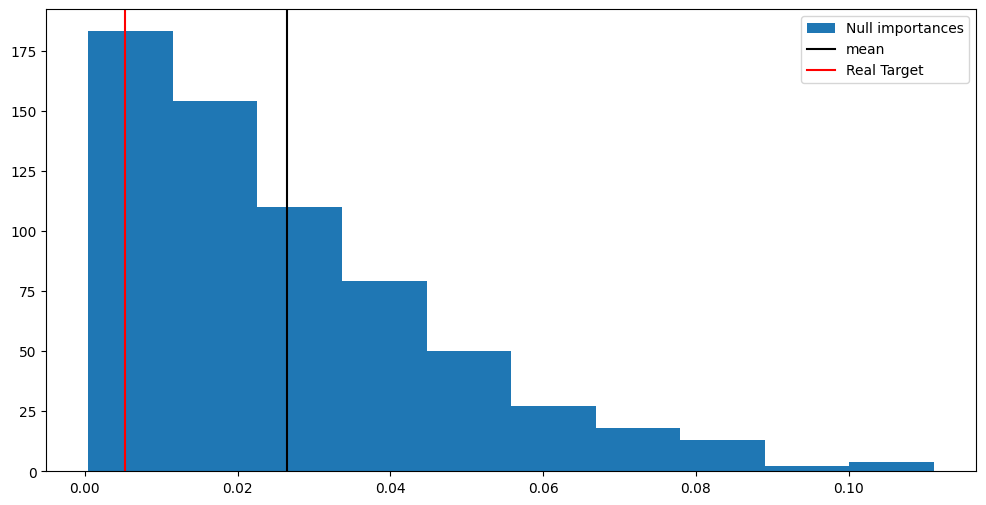

In [165]:
display_distributions(actual_imp_df, null_imp_df, 'f_0')

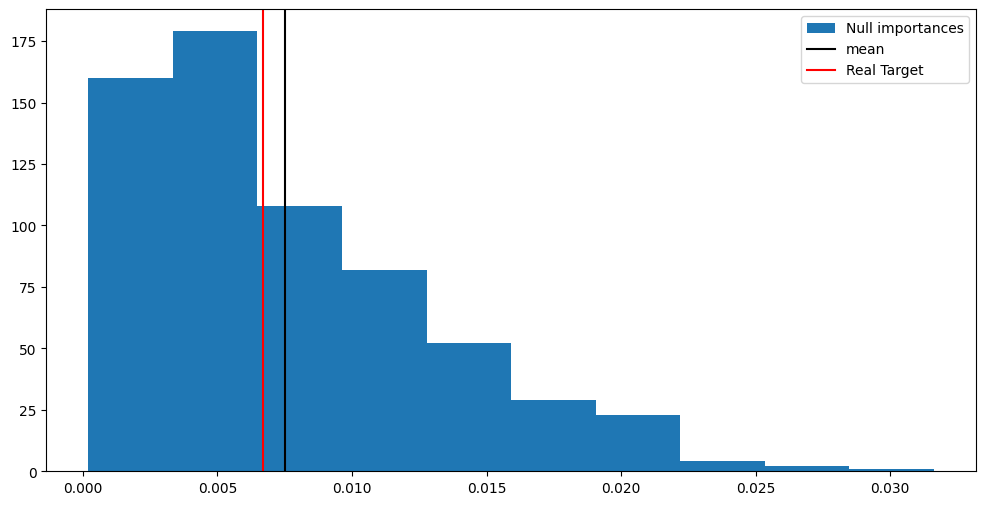

In [166]:
display_distributions(actual_imp_df, null_imp_df, 'f_575')

In [155]:
feature_scores = []
for _f in actual_imp_df['feature'].unique():
    f_null_imps_gain = null_imp_df.loc[null_imp_df['feature'] == _f, 'weight'].values
    f_act_imps_gain = actual_imp_df.loc[actual_imp_df['feature'] == _f, 'weight'].mean()

    score = ( f_act_imps_gain - np.mean(f_null_imps_gain) ) / np.std(f_null_imps_gain)
    feature_scores.append( (_f, score) )

scores_df = pd.DataFrame(feature_scores, columns=['feature', 'score'])

In [188]:
scores_df = scores_df.sort_values('score', ascending=False)
scores_df

,feature,score
575,f_575,-0.149047
577,f_577,-0.149047
574,f_574,-0.763827
576,f_576,-0.763827
0,f_0,-1.013371
...,...,...
374,f_374,-1.388434
452,f_452,-1.392297
647,f_647,-1.400030
385,f_385,-1.404465


In [190]:
metric_df = []
for i in tqdm(range(1, feat_df.shape[1])):
    imp_feats = scores_df.head(i).feature.tolist()

    model = Ridge(9.17e-5)
    oof_pred = cross_val_predict(model, feat_df[imp_feats], Y_train, cv=3)
    sigma_pred = mean_squared_error(Y_train, oof_pred, squared=False)
    
    score = get_cv_score(oof_pred, sigma_pred)
    metric_df.append( (i, score) )

  0%|          | 0/859 [00:00<?, ?it/s]

In [191]:
metric_df = pd.DataFrame(metric_df)

In [193]:
metric_df.columns = ['num_feats', 'score']

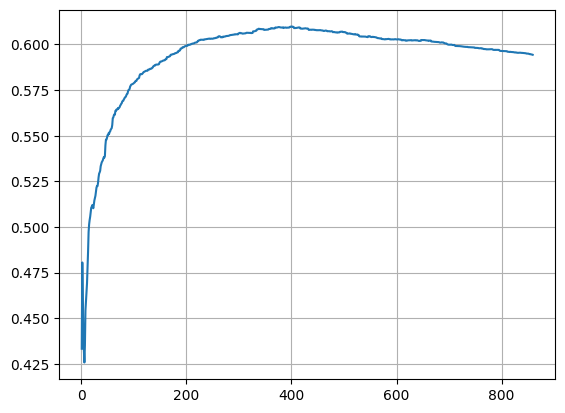

In [195]:
plt.plot(metric_df.num_feats, metric_df.score)
plt.grid()

In [199]:
metric_df[metric_df.num_feats.isin([400, 859])]  # 

,num_feats,score
399,400,0.609751
858,859,0.594329


## CV

In [201]:
train_adc_df.star.value_counts()

star
0    346
1    327
Name: count, dtype: int64

In [204]:
class StarSplitter:
    def __init__(self, split_indices):
        self.split_indices = split_indices

    def split(self, X, y=None, groups=None):
        for train_index, test_index in self.split_indices:
            yield train_index, test_index

    def get_n_splits(self, X=None, y=None, groups=None):
        return len(self.split_indices)

In [208]:
star0_indices = np.where(train_adc_df.star.values == 0)[0]
star1_indices = np.where(train_adc_df.star.values == 1)[0]

In [209]:
split_indices = [
    (star0_indices, star1_indices),
    (star1_indices, star0_indices),
]

In [210]:
star_cv = StarSplitter(split_indices)

### Ridge feat400

In [211]:
imp_feats = scores_df.head(400).feature.tolist()

model = Ridge(9.17e-5)
oof_pred = cross_val_predict(model, feat_df[imp_feats], Y_train, cv=2)
sigma_pred = mean_squared_error(Y_train, oof_pred, squared=False)

score = get_cv_score(oof_pred, sigma_pred)
score

0.6018269147223929

In [213]:
imp_feats = scores_df.head(400).feature.tolist()

model = Ridge(9.17e-5)
oof_pred = cross_val_predict(model, feat_df[imp_feats], Y_train, cv=star_cv)
sigma_pred = mean_squared_error(Y_train, oof_pred, squared=False)

score = get_cv_score(oof_pred, sigma_pred)
score

0.500409428469406

### Ridge feat860

In [212]:
imp_feats = scores_df.head(860).feature.tolist()

model = Ridge(9.17e-5)
oof_pred = cross_val_predict(model, feat_df[imp_feats], Y_train, cv=2)
sigma_pred = mean_squared_error(Y_train, oof_pred, squared=False)

score = get_cv_score(oof_pred, sigma_pred)
score

0.5865322258104716

In [214]:
imp_feats = scores_df.head(860).feature.tolist()

model = Ridge(9.17e-5)
oof_pred = cross_val_predict(model, feat_df[imp_feats], Y_train, cv=star_cv)
sigma_pred = mean_squared_error(Y_train, oof_pred, squared=False)

score = get_cv_score(oof_pred, sigma_pred)
score

0.4719441882568932

### No model

In [228]:
pred = train_adc_df.trim_a_depth.values
pred = np.tile(pred.reshape(-1, 1), (1, 283))
pred.shape

(673, 283)

In [229]:
sigma_pred = mean_squared_error(Y_train, pred, squared=False)
sigma_pred

9.820398262059147e-05

In [230]:
score = get_cv_score(pred, sigma_pred)
score

0.4946636702957416

## Ensemble

- Spend most of time on feature engineering and get a few good and diverse models
- For stacking, it's really only important to have one or two models that score well individually. After that, it's all about diversity, and even very weak models can help.

### Voting (加权平均)

In [232]:
model = Ridge(9.17e-5)
model.fit(X_train, Y_train)

Ridge(alpha=9.17e-05)

In [233]:
# fake
X_test = X_train

In [235]:
ridge_pred = model.predict(X_test)
ridge_pred.shape

(673, 283)

In [238]:
pred = train_adc_df.trim_a_depth.values
pred = np.tile(pred.reshape(-1, 1), (1, 283))
pred.shape

(673, 283)

In [239]:
# fake
rule_pred = pred
rule_pred.shape

(673, 283)

In [240]:
avg_pred = 0.2 * ridge_pred + 0.8 * rule_pred
avg_pred.shape

(673, 283)

### Stacking

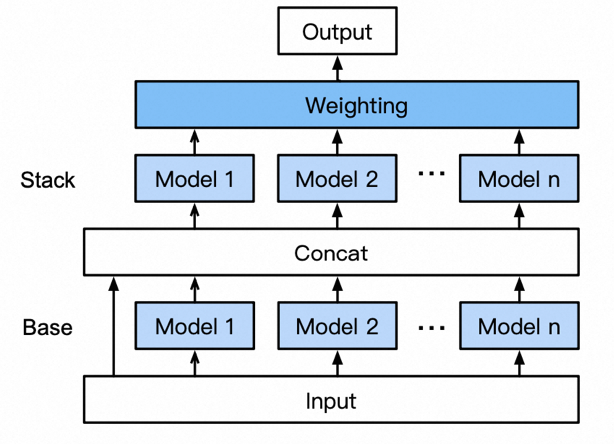

In [265]:
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression

In [250]:
def do_cv(model, X_train, Y_train, X_test, nfold=5):
    kfold = KFold(n_splits=nfold)
    indices = np.arange(X_train.shape[0])
    oof = np.empty_like(Y_train, dtype=np.float32)
    pred = np.zeros((X_test.shape[0], Y_train.shape[1]), dtype=np.float32)
    for trn_idx, val_idx in kfold.split(indices):
        model.fit(X_train[trn_idx], Y_train[trn_idx])
        oof[val_idx] = model.predict(X_train[val_idx])
        pred += model.predict(X_test) / nfold
    
    sigma_pred = mean_squared_error(Y_train, oof, squared=False)
    score = get_cv_score(oof, sigma_pred)
    return score, oof, pred

In [251]:
model = Ridge(9.17e-5)
X_test = X_train  # fake

In [255]:
ridge_score, ridge_oof, ridge_pred = do_cv(model, X_train, Y_train, X_test)

In [256]:
ridge_score

0.5934660853335351

In [257]:
ridge_oof.shape, ridge_pred.shape

((673, 283), (673, 283))

In [259]:
model = KNeighborsRegressor()
X_test = X_train  # fake

In [260]:
knn_score, knn_oof, knn_pred = do_cv(model, X_train, Y_train, X_test)

In [261]:
knn_score

0.447246575245459

In [262]:
knn_oof.shape, knn_pred.shape

((673, 283), (673, 283))

In [264]:
stack_model = LinearRegression()

In [266]:
oof_feat = np.column_stack([ridge_oof, knn_oof])
oof_feat.shape

(673, 566)

In [267]:
stack_model.fit(oof_feat, Y_train)

LinearRegression()

In [268]:
test_feat = np.column_stack([ridge_pred, knn_pred])
test_feat.shape

(673, 566)

In [269]:
stack_pred = stack_model.predict(test_feat)

In [270]:
stack_pred.shape

(673, 283)